In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import metrics
import datetime
import matplotlib.pyplot as plt


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


def to_sequences(seq_size, obs, target_col):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs.iloc[i : (i + seq_size), target_col:].values
        after_window = obs.iloc[i + seq_size, target_col]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))

    return x_train, y_train


def backtest(
    pred,
    y_test,
    periods_per_day=10,
    capital=1_000_000,
    mult=10_000,
    contracts=1,
    idx=None,
):
    total = 0
    pnls = []
    counter = 0

    # TODO: Fix to correct date indexing.
    # idx_n = []

    for x in range(len(pred)):
        if pred[x] > 0.0:
            total += y_test[x] * mult * contracts
        elif pred[x] < 0.0:
            total -= y_test[x] * mult * contracts
        if counter % periods_per_day == 0:
            pnls.append(total)
            # idx_n.append(idx[counter])
        counter += 1

    rets = pd.DataFrame(data=pnls, columns=["cum_pnl"])  # , index=idx_n)
    rets["portfolio"] = rets["cum_pnl"] + capital
    rets["pct_pnl"] = rets["portfolio"].pct_change()
    rets = rets.dropna()

    return rets


def perf_summ(data: pd.DataFrame, adj: int = 12, title="Metric") -> pd.DataFrame:
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    # TODO: Add absolute value/fix Calmar calculation.
    summary["Calmar Ratio"] = np.abs(((data.mean() * adj) / drawdowns.min()))

    return summary.T


periods_per_day = 10

In [2]:
fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=",", na_values=["-1"], index_col=False)
df['Date'] = pd.to_datetime(df['Date'])
target_col = "fut"

df = df.set_index("Date")
df = df.drop("Sum", axis=1)

col = df.pop(target_col)
df.insert(0, col.name, col)

df = df.reset_index(drop=False)

df["CosHour"] = np.cos(2 * np.pi * df["Date"].dt.hour / 24)
df["SinHour"] = np.sin(2 * np.pi * df["Date"].dt.hour / 24)
df["CosDay"] = np.cos(2 * np.pi * df["Date"].dt.day / 30)
df["SinDay"] = np.sin(2 * np.pi * df["Date"].dt.day / 30)
df["SinMonth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["SinMoth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["Year"] = df["Date"].dt.year

df = df.dropna()
df = df.drop("Date", axis=1)

df_train = df.iloc[:1000, :]
df_test = df.iloc[950:, :]

x_train = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]

x_train = (x_train - x_train.expanding().mean()) / x_train.expanding().std()
y_train = y_train.iloc[1:]
x_train = x_train.dropna()

x_test = df_test.drop(target_col, axis=1)
y_test = df_test[target_col]

y_train = y_train.to_numpy().reshape((-1, 1))
y_test = y_test.to_numpy().reshape((-1, 1))

df = (df - df.expanding().mean()) / df.expanding().std()

x_train, y_train = to_sequences(50, df_train, 0)
x_test, y_test = to_sequences(50, df_test, 0)

In [50]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 26)]    0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 100, 26)     52          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 100, 26)     109594      ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [3]:
def run_stepped_inc(model, x_test, y_test, step_size, stop_at=None, **model_kwargs):
    stop_at = len(x_test) if stop_at is None else stop_at
    x_test = x_test[:stop_at]
    y_test = y_test[:stop_at]
    preds = []

    for i in range(0, stop_at, step_size):
        # Check if we reached end of data.
        if i + step_size >= stop_at:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i : i + step_size]
            y_step = y_test[i : i + step_size]

        # Predict the data.
        pred = model.predict(x_step)

        # Append to output list.
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()

        # Re-fit the model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step, y_step, **model_kwargs)
        except:
            model.fit(x_step, y_step)
    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test[:stop_at]

def run_stepped_retrain(model, x_test, y_test, step_size, stop_at=None, **model_kwargs):
    stop_at = len(x_test) if stop_at is None else stop_at
    x_test = x_test[:stop_at]
    y_test = y_test[:stop_at]
    preds = []
    
    for i in range(0, stop_at, step_size):
        if i + step_size >= stop_at:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i:i + step_size]
            y_step = y_test[i:i + step_size]
        
        x_step_train = x_test[:i + step_size]
        y_step_train = y_test[:i + step_size]
        
        # Predict the data.
        pred = model.predict(x_step)
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()
        
        # Re-Train entire model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step_train, y_step_train, **model_kwargs)
        except:
            model.fit(x_step_train, y_step_train)

    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test

x, y = run_stepped_inc(
    model, x_test, y_test, step_size=25, epochs=5, batch_size=64, callbacks=callbacks
)

In [6]:
def summ_and_plot(x, y, periods_per_day=10, mult=10_000, capital=1_000_000, contracts=1, adj=252, title=""):
    rets = backtest(x, y, periods_per_day=periods_per_day, mult=mult, capital=capital, contracts=contracts)
    summ = perf_summ(rets["pct_pnl"], adj=adj, title=title)
    display(summ)
    plt.plot(rets["portfolio"])
    plt.plot(rets["portfolio"].cummax())
    plt.title(title)
    plt.show()
    return summ, rets

rets_agg, tf_rets25 = summ_and_plot(x, y, title="Transformer Step Size 25")

In [ ]:
x, y = run_stepped_inc(
    model, x_test, y_test, step_size=50, epochs=5, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 50"], tf_rets50 = summ_and_plot(x, y, title="Transformer Step Size 50")

In [ ]:
x, y = run_stepped_inc(
    model, x_test, y_test, step_size=100, epochs=5, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 100"], tf_rets100 = summ_and_plot(x, y, title="Transformer Step Size 100")

In [ ]:
x, y = run_stepped_inc(
    model, x_test, y_test, step_size=500, epochs=5, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 500"], tf_rets500 = summ_and_plot(x, y, title="Transformer Step Size 500")

In [ ]:
display(rets_agg)
plt.plot(tf_rets25["portfolio"], label="25")
plt.plot(tf_rets50["portfolio"], label="50")
plt.plot(tf_rets100["portfolio"], label="100")
plt.plot(tf_rets500["portfolio"], label="500")
plt.legend()
plt.show()

In [4]:
from xgboost import XGBRegressor

# XGBoost and Regression Models.
df_train_mod = df_train.copy()
df_test_mod = df_test.iloc[100:, :].copy()

x_train_mod = df_train_mod.drop(target_col, axis=1)
y_train_mod = df_train_mod[target_col].values

x_test_mod = df_test_mod.drop(target_col, axis=1)
y_test_mod = df_test_mod[target_col].values

xgb_model = XGBRegressor().fit(x_train_mod, y_train_mod)
x, y = run_stepped_retrain(xgb_model, x_test_mod, y_test_mod, step_size=25)
rets_agg["XGBoost Step Size 25"], xgb_rets = summ_and_plot(x, y, title="XGBoost")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, random_state=1)
forest.fit(x_train_mod, y_train_mod)
x, y = run_stepped_retrain(forest, x_test_mod, y_test_mod, step_size=10)
rets_agg["Random Forest Step Size 25"], rf_rets = summ_and_plot(x, y, title="Random Forest")

,Window=50
Annualized Return,0.599204
Annualized Volatility,0.356614
Annualized Sharpe Ratio,1.680260
Annualized Sortino Ratio,2.713837
Skewness,0.409190
Kurtosis,3.239441
VaR (0.05),-0.029989
CVaR (0.05),-0.044559
Min,-0.097385
Max,0.139956


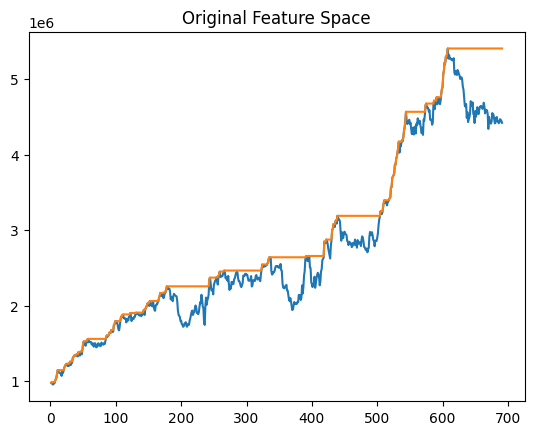

In [56]:
# rets = backtest(x, y, periods_per_day=10, mult=1, capital=3.27)
# rets = backtest(x, y, periods_per_day=10, mult=10_000, capital=1_000_000,contracts=100)
# display(perf_summ(rets["pct_pnl"], adj=252, title="Window=50"))
# agg_perf = perf_summ(rets["pct_pnl"], adj=252, title="Transformer")
# plt.plot(rets["portfolio"])
# plt.plot(rets["portfolio"].cummax())
# plt.title("Original Feature Space")
# plt.show()

# # Correct index needs to still be put in 

In [1]:
x_train

NameError: name 'x_train' is not defined